In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-18 11:21:25.624986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 11:21:26.260520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-18 11:21:26.953282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 11:21:26.978813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Sergipe - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_mo_model_input_SE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Consumo de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,23.616,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,21.357,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,20.059,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,19.920,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,19.962,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


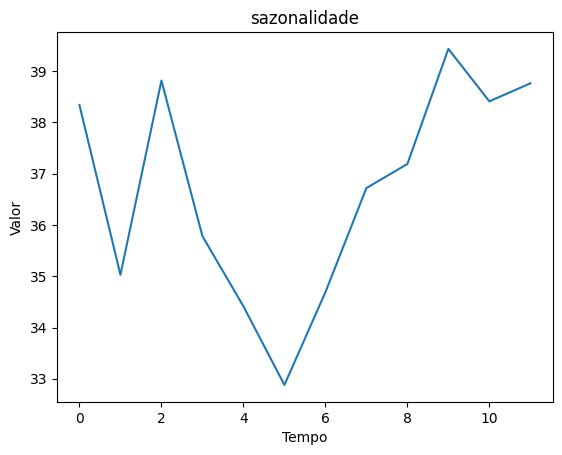

,sazonalidade
sazonalidade,
0,38.340633
1,35.029357
2,38.817981
3,35.782684
4,34.414344
5,32.880261
6,34.688258
7,36.720866
8,37.190207


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,38.340633,23.616
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,35.029357,21.357
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,38.817981,20.059
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,35.782684,19.920
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,34.414344,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.414344,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.880261,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.688258,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.720866,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Sergipe - Consumo de Cimento (t), Length: 249, dtype: float64

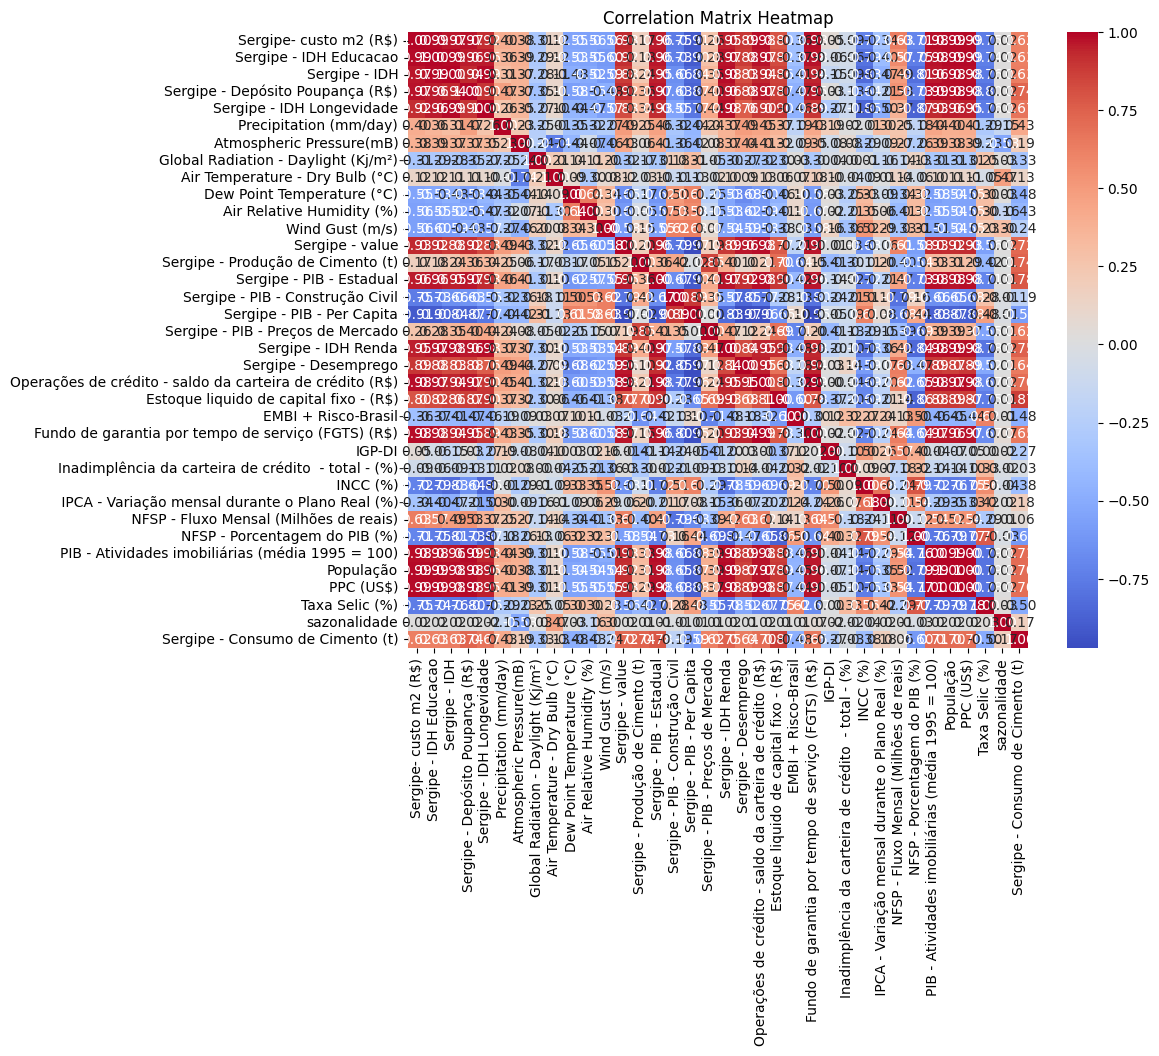

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Sergipe- custo m2 (R$),1.266947e+06
1,Sergipe - IDH Educacao,1.077579e+09
2,Sergipe - IDH,4.285863e+09
3,Sergipe - Depósito Poupança (R$),1.286735e+05
4,Sergipe - IDH Longevidade,1.438450e+09
5,Precipitation (mm/day),4.895785e+01
6,Atmospheric Pressure(mB),1.185986e+07
7,Global Radiation - Daylight (Kj/m²),6.088198e+00
8,Air Temperature - Dry Bulb (°C),2.955999e+04
9,Dew Point Temperature (°C),5.570329e+02


In [14]:
data =data.drop(['Air Temperature - Dry Bulb (°C)', 
                 'Wind Gust (m/s)',
                 'Global Radiation - Daylight (Kj/m²)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,9513.254800,0.599319,1.618045e+06,1.154340,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,8.389943,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,38.340633
1,9606.199031,0.599716,1.622416e+06,1.155152,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,8.384067,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,35.029357
2,9693.715697,0.600113,1.626787e+06,1.155625,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,8.378190,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,38.817981
3,9777.797840,0.600511,1.631158e+06,1.155676,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,8.372313,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,35.782684
4,9852.699220,0.600908,1.635529e+06,1.195157,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,8.366437,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,34.414344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,24996.436197,0.654943,4.185052e+06,1.877722,1182.489824,26.309783,19.110255,62.776724,2.467588,0.473623,177.775895,2.466524e+07,1.207894e+06,13.466062,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,36.720866
200,25215.974769,0.655058,4.242103e+06,1.754293,1309.847026,26.644608,18.659512,59.668954,2.737960,0.476028,178.481972,2.464323e+07,1.208870e+06,13.458555,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,37.190207
201,25442.123214,0.655173,4.299155e+06,1.680986,1400.093654,27.039704,18.452147,57.764811,2.916133,0.478594,179.110237,2.462122e+07,1.209846e+06,13.451047,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,39.435055
202,25683.204148,0.655287,4.356206e+06,1.603036,1481.328997,27.430714,18.588949,57.689620,2.963216,0.481268,179.032013,2.459921e+07,1.210822e+06,13.443540,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,38.412874


In [15]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.893614,-1.629309,-0.605450,0.052788,-0.317465,1.099085,1.034914,0.722720,-1.384341,-1.581672,-1.833875,-0.118504,-0.919815,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.870066,-1.623735,-0.603562,0.052788,-0.316314,1.094875,1.031094,0.721006,-1.349665,-1.603677,-1.812613,-0.089466,-0.922138,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.846519,-1.618160,-0.602460,0.052788,-0.315643,1.092420,1.028866,0.720007,-1.315963,-1.537085,-1.791351,-0.060429,-0.924460,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.822972,-1.612585,-0.602342,0.052788,-0.315572,1.092157,1.028627,0.719900,-1.283269,-1.498634,-1.770089,-0.031391,-0.926783,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.799425,-1.607011,-0.510503,0.019566,-0.119617,1.058268,0.972580,0.725283,-1.255447,-1.457308,-1.748827,-0.002354,-0.929106,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.403043,1.644574,1.077268,-0.309424,-0.596958,-0.816103,-1.072413,-0.523734,1.186239,-0.917146,0.860563,-1.452891,1.086589,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.409841,1.717336,0.790149,-0.279352,-0.108420,-0.996716,-1.444734,-0.213175,1.232306,-0.898366,0.841233,-1.428359,1.083622,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.416639,1.790098,0.619624,-0.258043,0.468060,-1.079808,-1.672857,-0.008518,1.281463,-0.881656,0.821902,-1.403826,1.080654,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,1.423436,1.862859,0.438299,-0.238861,1.038577,-1.024991,-1.681865,0.045563,1.332691,-0.883736,0.802572,-1.379294,1.077687,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.893614,-1.629309,-0.605450,0.052788,-0.317465,1.099085,1.034914,0.722720,-1.384341,-1.581672,-1.833875,-0.118504,-0.919815,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.870066,-1.623735,-0.603562,0.052788,-0.316314,1.094875,1.031094,0.721006,-1.349665,-1.603677,-1.812613,-0.089466,-0.922138,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.846519,-1.618160,-0.602460,0.052788,-0.315643,1.092420,1.028866,0.720007,-1.315963,-1.537085,-1.791351,-0.060429,-0.924460,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.822972,-1.612585,-0.602342,0.052788,-0.315572,1.092157,1.028627,0.719900,-1.283269,-1.498634,-1.770089,-0.031391,-0.926783,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.799425,-1.607011,-0.510503,0.019566,-0.119617,1.058268,0.972580,0.725283,-1.255447,-1.457308,-1.748827,-0.002354,-0.929106,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.367516,1.093502,-0.736970,-0.258794,-0.564305,-0.768088,-0.736093,-0.135331,0.845026,-1.089977,1.038094,-1.657564,1.127181,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,1.365105,1.101850,-0.759682,-0.242443,-0.058048,-0.668625,-0.772706,0.110991,0.840673,-1.080602,1.029650,-1.650975,1.123217,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.362693,1.110198,-0.796708,-0.230489,0.530529,-0.576032,-0.841043,0.168950,0.842009,-1.040319,1.021207,-1.644386,1.119253,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,1.360281,1.118547,-0.677031,-0.225564,1.113734,-0.443317,-0.863226,0.169146,0.854804,-1.028587,1.012764,-1.637797,1.115289,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
187    44.612
188    47.883
189    61.314
190    41.190
191    41.837
Name: Sergipe - Consumo de Cimento (t), Length: 192, dtype: float64

In [18]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [19]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 25)

In [20]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,1.167311,0.657742,-0.210457,-0.241079,1.466166,-0.321905,-0.836607,0.128058,1.454088,-0.007041,1.089763,-1.086821,1.269788,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,1.178969,0.669485,-0.052452,-0.249025,1.581187,-0.357259,-0.910107,-0.178434,1.432900,-0.073924,1.093373,-1.121746,1.263063,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,1.190627,0.681227,0.067296,-0.272393,1.251184,-0.383928,-0.833014,-0.746848,1.410142,-0.130780,1.096983,-1.156670,1.256338,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,1.202286,0.692969,0.141035,-0.288758,0.638092,-0.525721,-0.809059,-1.334486,1.387171,-0.194382,1.100594,-1.191594,1.249613,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,1.213944,0.704711,0.438096,-0.296717,-0.082061,-0.679396,-0.766131,-1.965969,1.364785,-0.271605,1.104204,-1.226519,1.242887,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,1.225602,0.716453,-0.065063,-0.290906,-0.548236,-0.796653,-0.769307,-2.458794,1.345937,-0.336790,1.107814,-1.261443,1.236162,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,1.237261,0.728195,-0.680308,-0.273113,-0.681119,-0.855727,-0.808395,-2.715753,1.326705,-0.395831,1.111424,-1.296367,1.229437,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,1.248919,0.739937,-0.548375,-0.253678,-0.539519,-0.798783,-0.791108,-2.924210,1.307401,-0.444819,1.115035,-1.331291,1.222712,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,1.260577,0.751680,-0.469825,-0.234757,-0.207235,-0.681063,-0.760309,-3.020945,1.280942,-0.504118,1.118645,-1.366216,1.215987,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,1.272235,0.763422,-0.658991,-0.218959,0.248763,-0.612309,-0.822096,-3.072835,1.253455,-0.558873,1.122255,-1.401140,1.209261,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 25)

In [22]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [23]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [24]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [25]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1565470453, 2138396400, 2006867645, 303570738, 1068982151, 3820422177, 3072319826, 866319678, 942742345, 730161709]


Step: 0 ___________________________________________


2023-11-18 11:21:30.117365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 11:21:30.117553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 11:21:30.117716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 41.51127624511719
winner_seed: 1565470453


Step: 1 ___________________________________________
val_loss: 34.37917709350586
winner_seed: 2138396400


Step: 2 ___________________________________________
val_loss: 39.1390495300293


Step: 3 ___________________________________________
val_loss: 35.670379638671875


Step: 4 ___________________________________________
val_loss: 34.9694938659668


Step: 5 ___________________________________________
val_loss: 38.304718017578125


Step: 6 ___________________________________________
val_loss: 39.05786895751953


Step: 7 ___________________________________________
val_loss: 42.86345291137695


Step: 8 ___________________________________________
val_loss: 36.38051986694336


Step: 9 ___________________________________________
val_loss: 44.977169036865234


final_seed: 2138396400


In [26]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 102ms/step - loss: 1282.4885 - val_loss: 80.9576
Epoch 2/10000
5/5 [==============================] - 0s 11ms/step - loss: 94.2221 - val_loss: 48.0898
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 75.1001 - val_loss: 49.8189
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 87.1480 - val_loss: 78.4313
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 58.2371 - val_loss: 68.7281
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 48.8153 - val_loss: 505.3103
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 54.6926 - val_loss: 137.9067
Epoch 8/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.0599 - val_loss: 52.0109
Epoch 9/10000
5/5 [==============================] - 0s 11ms/step - loss: 63.5363 - val_loss: 243.4832
Epoch 10/10000
5/5 [==============================] - 0s 10ms/step - loss: 37

Epoch 81/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3790 - val_loss: 38.0040
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.7492 - val_loss: 45.2353
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.2971 - val_loss: 37.3662
Epoch 84/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.6308 - val_loss: 38.6199
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.2491 - val_loss: 37.5774
Epoch 86/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.5713 - val_loss: 34.9545
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.2490 - val_loss: 40.2796
Epoch 88/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.8227 - val_loss: 57.0370
Epoch 89/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.5627 - val_loss: 36.1237
Epoch 90/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.8622 - val

5/5 [==============================] - 0s 9ms/step - loss: 7.5346 - val_loss: 33.4527
Epoch 162/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.6850 - val_loss: 36.1243
Epoch 163/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.3274 - val_loss: 34.0881
Epoch 164/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.3485 - val_loss: 32.9585
Epoch 165/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.4035 - val_loss: 32.7111
Epoch 166/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.9610 - val_loss: 34.3501
Epoch 167/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.9900 - val_loss: 33.3170
Epoch 168/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.5364 - val_loss: 39.0659
Epoch 169/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.2578 - val_loss: 33.0662
Epoch 170/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.6931 - val_loss: 36.6

5/5 [==============================] - 0s 8ms/step - loss: 6.5127 - val_loss: 33.6113
Epoch 242/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.1529 - val_loss: 33.4659
Epoch 243/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.6361 - val_loss: 34.6160
Epoch 244/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.6541 - val_loss: 34.9028
Epoch 245/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.7982 - val_loss: 35.4461
Epoch 246/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.5195 - val_loss: 36.9460
Epoch 247/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.9911 - val_loss: 34.1720
Epoch 248/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.8340 - val_loss: 35.5833
Epoch 249/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.7952 - val_loss: 35.7685
Epoch 250/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.9976 - val_loss: 33.

5/5 [==============================] - 0s 9ms/step - loss: 5.4844 - val_loss: 34.8540
Epoch 322/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.8711 - val_loss: 35.2706
Epoch 323/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.6805 - val_loss: 34.9326
Epoch 324/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.6255 - val_loss: 33.5956
Epoch 325/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.2615 - val_loss: 34.0307
Epoch 326/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.6158 - val_loss: 34.1638
Epoch 327/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.6388 - val_loss: 35.9237
Epoch 328/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.0167 - val_loss: 34.7039
Epoch 329/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.1138 - val_loss: 34.9550
Epoch 330/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.6200 - val_loss: 36

5/5 [==============================] - 0s 9ms/step - loss: 5.6639 - val_loss: 38.3241
Epoch 402/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.0004 - val_loss: 35.4467
Epoch 403/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.8445 - val_loss: 39.6842
Epoch 404/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.3437 - val_loss: 36.3817
Epoch 405/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.6937 - val_loss: 34.5538
Epoch 406/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.2150 - val_loss: 35.9285
Epoch 407/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.5957 - val_loss: 36.2727
Epoch 408/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.5718 - val_loss: 38.4062
Epoch 409/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.8299 - val_loss: 35.4646
Epoch 410/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.5651 - val_loss: 35.8

5/5 [==============================] - 0s 8ms/step - loss: 5.5141 - val_loss: 35.5476
Epoch 482/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.3803 - val_loss: 35.7779
Epoch 483/10000
5/5 [==============================] - 0s 10ms/step - loss: 5.6335 - val_loss: 35.6027
Epoch 484/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.5296 - val_loss: 35.5985
Epoch 485/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.8377 - val_loss: 36.3343
Epoch 486/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.2680 - val_loss: 35.2412
Epoch 487/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.4796 - val_loss: 35.1916
Epoch 488/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.4437 - val_loss: 34.6496
Epoch 489/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.6726 - val_loss: 35.1429
Epoch 490/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.1737 - val_loss: 34.

5/5 [==============================] - 0s 9ms/step - loss: 5.5849 - val_loss: 38.7000
Epoch 562/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.1768 - val_loss: 36.5481
Epoch 563/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.5176 - val_loss: 36.6794
Epoch 564/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.4190 - val_loss: 37.7952
Epoch 565/10000
5/5 [==============================] - 0s 10ms/step - loss: 5.5777 - val_loss: 36.2904
Epoch 566/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.1268 - val_loss: 37.2332
Epoch 567/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.8179 - val_loss: 36.3246
Epoch 568/10000
5/5 [==============================] - 0s 10ms/step - loss: 5.5727 - val_loss: 37.3635
Epoch 569/10000
5/5 [==============================] - 0s 10ms/step - loss: 5.5441 - val_loss: 40.0592
Epoch 570/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.5306 - val_loss: 

5/5 [==============================] - 0s 9ms/step - loss: 5.3293 - val_loss: 38.4358
Epoch 642/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.8257 - val_loss: 38.2993
Epoch 643/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.4158 - val_loss: 43.1119
Epoch 644/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.1779 - val_loss: 38.5353
Epoch 645/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.9966 - val_loss: 36.7935
Epoch 646/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.2535 - val_loss: 37.8121
Epoch 647/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.9537 - val_loss: 37.0787
Epoch 648/10000
5/5 [==============================] - 0s 8ms/step - loss: 4.7488 - val_loss: 36.3094
Epoch 649/10000
5/5 [==============================] - 0s 8ms/step - loss: 4.9315 - val_loss: 37.0805
Epoch 650/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.0659 - val_loss: 36.

5/5 [==============================] - 0s 8ms/step - loss: 4.8340 - val_loss: 38.1558
Epoch 722/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.3275 - val_loss: 38.8035
Epoch 723/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.4231 - val_loss: 37.7028
Epoch 724/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.9166 - val_loss: 37.9183
Epoch 725/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.7232 - val_loss: 37.7436
Epoch 726/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.9071 - val_loss: 37.9096
Epoch 727/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.2058 - val_loss: 37.6091
Epoch 728/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.6948 - val_loss: 39.1690
Epoch 729/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.0046 - val_loss: 37.6251
Epoch 730/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.6739 - val_loss: 39.

5/5 [==============================] - 0s 8ms/step - loss: 5.0786 - val_loss: 39.9982
Epoch 802/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.2273 - val_loss: 43.5375
Epoch 803/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.3613 - val_loss: 39.4132
Epoch 804/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.5292 - val_loss: 39.0623
Epoch 805/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.1043 - val_loss: 38.6869
Epoch 806/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.5600 - val_loss: 38.9926
Epoch 807/10000
5/5 [==============================] - 0s 8ms/step - loss: 4.8661 - val_loss: 38.6530
Epoch 808/10000
5/5 [==============================] - 0s 8ms/step - loss: 4.9581 - val_loss: 42.3221
Epoch 809/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.9431 - val_loss: 38.4822
Epoch 810/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.5759 - val_loss: 38.

5/5 [==============================] - 0s 9ms/step - loss: 5.2289 - val_loss: 39.6210
Epoch 882/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.3020 - val_loss: 38.8397
Epoch 883/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.6756 - val_loss: 38.5060
Epoch 884/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.6531 - val_loss: 39.8590
Epoch 885/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.4893 - val_loss: 38.6289
Epoch 886/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.7512 - val_loss: 39.6786
Epoch 887/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.8784 - val_loss: 42.7230
Epoch 888/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.4993 - val_loss: 42.9608
Epoch 889/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.3001 - val_loss: 38.5783
Epoch 890/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.4151 - val_loss: 39.5

5/5 [==============================] - 0s 8ms/step - loss: 4.9777 - val_loss: 38.6127
Epoch 962/10000
5/5 [==============================] - 0s 8ms/step - loss: 4.7892 - val_loss: 41.2224
Epoch 963/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.8375 - val_loss: 38.7802
Epoch 964/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.1571 - val_loss: 38.8354
Epoch 965/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.4702 - val_loss: 38.8915
Epoch 966/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.8247 - val_loss: 38.8578
Epoch 967/10000
5/5 [==============================] - 0s 8ms/step - loss: 4.8138 - val_loss: 40.0433
Epoch 968/10000
5/5 [==============================] - 0s 8ms/step - loss: 4.0125 - val_loss: 40.0112
Epoch 969/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.1884 - val_loss: 39.1893
Epoch 970/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.5608 - val_loss: 38.

In [27]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [28]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,42.252525,41.183235,40.478336,39.724392,39.242596,39.788795,40.570374,40.670795,40.926567,40.8801,40.540928,40.132965
Target,42.517,44.162,53.871,44.494,37.865,37.706,38.178,42.899,45.714,49.01,42.946,32.132
Error,0.264473,2.978764,13.392662,4.769608,1.377594,2.082794,2.392372,2.228203,4.787434,8.129898,2.405071,8.000965


In [29]:
display(mae)
display(mape)

4.40082

0.100942604

In [30]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [31]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[486.39163]] - Target[511.49399999999997]| =  Error: [[25.102356]]; MAPE:[[0.04907654]]


[array([[25.102356]], dtype=float32)]

25.102356

0.049076542